<h1> Bias Improvement in Biased Monte Carlo </h1>

<p> Ideally our bias would be the inverse of the Boltzmann factor of each state, so that all states are visited equally. In the biased system, the transition state isn't really a transition state at all -- it's the same Boltzmann factor as everything else, and doesn't prevent transitions. To do this, I have made a decent guess of the biases and run the simulation. Now based on those simulations I will make updated estimates of the free energy of each of the states, and then created improved weights. </p> 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import glob
%matplotlib inline

<h2> Read in the energy data, which contains state occupancy and bias </h2>

<p> We read in the energy.dat file as a fwf. Columns 5 and 6 represent the number of bonds, and the mindist bin respectively (remember, we binned the minimum distance, so we could bias with a square well). I'm going to combine the mindist and number of bonds values to create a reaction coordinate, which goes from -3 (when comp. nucleotides are furthest) to 4, when everything is bonded.</p> 

__energy.dat__ file layout: <br>


|time (steps)| potential energy/N | acceptance ratio (translational move) | acceptance ratio (rotational move) | acceptance ratio (volume move) | num bonds | min dist interface | weighting (from wfile) |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1000|-0.9|0.124|0.0|0.0|5|2|4000|

<p> Let's look at the trajectories. Equilibrate by removing the first 1000 steps, so it looks like we don't start from the same place. 
We want regular transitions between the states (i.e. sampling a uniform distribution). </p>

In [323]:
pwd

'/Users/roshanodonnell/PhD/ComputationalModels/Rosh'

## Reaction coordinate 

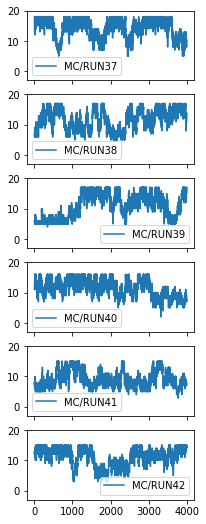

In [94]:
# Collect files and order them by last digits
file_name = [f for f in glob.iglob('MC/**', recursive=False) if 'RUN' in f]
file_num = [int(''.join(filter(lambda s: s.isdigit(), f))) for f in file_name] 
file_num, file_name = zip(*sorted(zip(file_num,file_name))) #sort two lists

# Choose which energy files to analyse and plot
data_set = []
start = -6; stop = 42
for file in file_name[start:stop]:
    react_coord, weights = [],[]
    with open(file+'/energy.dat') as f:
        for line in f:
            useful = line.split(' ')[-4:]
            react_coord.append(float(useful[0])-float(useful[2])); weights.append(float(useful[-1]))
    data_set.append([react_coord,weights])

# Plot reaction coordinate against time steps (not labelled)
f,ax = pl.subplots(len(data_set),1,figsize = (3,9),sharex = True)
chop = 1000 #100 x1000 steps
data_set = [[e[0][chop:],e[1][chop:]] for e in data_set]

for i in range(len(data_set)): #
    ax[i].plot(data_set[i][0],label=f'{file_name[i+start]}') 
    #print(file_name[i+start],np.mean(data_set[i][0]))
    ax[i].set_ylim(-3,20)
    ax[i].legend()

## Histogram reaction coordinate

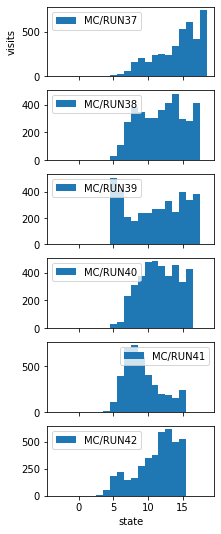

In [96]:
# Show histogram of each reaction coordinate - should be uniform over (-3,18)

f,ax = pl.subplots(len(data_set),1,figsize = (3,9),sharex = True)
_=ax[-1].set_xlabel('Reaction_coord')
_=ax[0].set_ylabel('Frequency')

min_val,max_val = -3.0,18
for i in range(len(data_set)):
    ax[i].hist(data_set[i][0],bins=np.arange(min_val-0.5,max_val+1.5,1),label=f'{file_name[i+start]}')
    ax[i].legend()
    #ax[i].set_ylim(0,100)

## Creating new weights

Freq per bin: 181


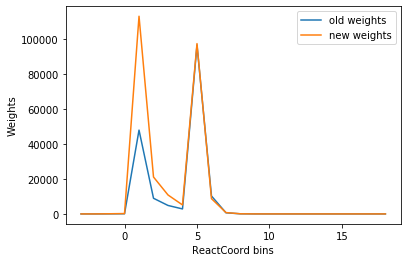

In [324]:
# Get old weights
old_w_file = 'MC/RUN39/wfile.txt'
old_w = []
with open(old_w_file) as f:
        for line in f:
            old_w.append(float(line.split(' ')[-1]))

# Create new weights based on old histogram
n,b = np.histogram(data_set[-1][0],bins=np.arange(min_val-0.5,max_val+1.5,1))
mean = len(data_set[-1][0])/(max_val-min_val+1) # i.e. 1000 runs, 22 coords, expect 1000/22 per bin
print(f'Freq per bin: {int(mean)}')
# Careful; if run was cut short/didn't end, len(data_set[i][0]) will be too short
res = n-mean; norm_res = res/np.std(res)
new_w = np.round(old_w*np.exp(-norm_res),6) #oxDNA goes to 6dp , have just done w'=w*exp(-norm_resid)
new_w = [w if w!=0. else 1e-6 for w in new_w] #prevents weight=0
        
x_range = np.arange(-3,19,1)
pl.plot(x_range,old_w,label='old weights')
pl.plot(x_range,new_w,label='new weights')
pl.xlabel('ReactCoord bins');pl.ylabel('Weights')
#pl.xlim(-3,18)#;pl.ylim(0,1)
pl.legend();pl.show()


## Write new weights file

In [109]:
# Writing a new wfile.txt
col1 = [0,0,0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
col2 = [3,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# file = open('MC/RUN42/wfile.txt', 'w')
# for i in range(len(col1)):
#     write_str = f'{col1[i]} {col2[i]} {new_w[i]}\n'
#     file.write(write_str)
# file.close()

## Trend in weights

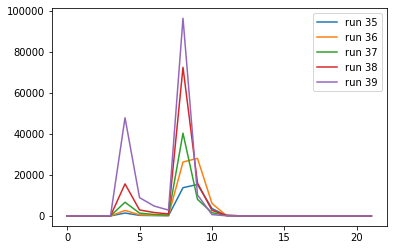

In [328]:
# Plot progress of weights files
all_weights = []
f1,f2=35,39
for i in range(f1,f2+1):
    file = f'MC/RUN{i}/wfile.txt'
    weights = []
    with open(file) as f:
        for line in f:
            weights.append(float(line.split(' ')[-1]))
    all_weights.append(weights)
for i,w in enumerate(all_weights):
    pl.plot(w,label=f'run {i+f1}')
    #pl.ylim(0,100)
    #pl.xlim(10,18)
pl.legend()

## Goodness of fit

In [326]:
# # Testing goodness of fit of distribution to a uniform distribution
# from scipy.stats import chisquare
# unif = np.array([mean]*len(old_w))
# dist = n
# goodness = chisquare(dist,unif).pvalue
# #pl.plot(dist);pl.plot(unif);pl.show()
# #print(goodness)

## Unbiasing

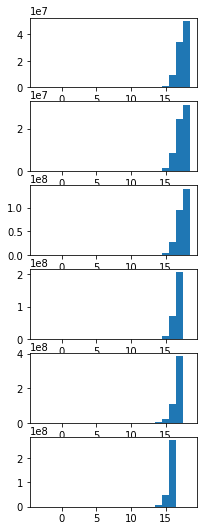

In [72]:
# Divide by reaction coordinate bias (modified the Boltzmann factor) 
# to get true occupancy of the reaction coordinate
# Average over your favourite runs (see previous cells for 'start','stop')
rel_prob = []
f,ax = pl.subplots(len(data_set),1,figsize = (3,9))
for i in range(len(data_set)):
    num = ax[i].hist(data_set[i][0],bins=np.arange(min_val-0.5,max_val+1.5),weights=1/np.array(data_set[i][1]))[0]
    rel_prob.append(num)
    

<p>Energy comes from $$p_i = \frac{1}{Z}exp\bigg(\frac{E_i}{k_BT}\bigg)$$ 
, and we normalised the probablity already, so just take logarithm, expressing energy in units of $k_BT$</p>

<p> Plot the free energy as a function of reaction coordinate </p>

## Probability 

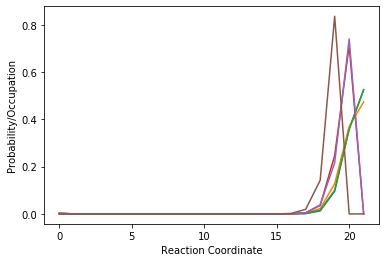

In [330]:
# For each run, append normalised histogram number = probability
norm_prob = [] 
for i in rel_prob: 
    pl.plot(i/sum(i))
    pl.ylabel('Probability/Occupation')
    pl.xlabel('Reaction Coordinate')
    norm_prob.append(i/sum(i))
pl.show()

## Free energy from reaction coordinate

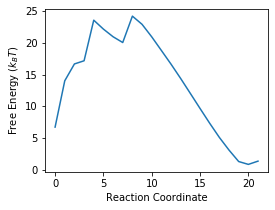

In [331]:
# Average the (normalised) histogram bins over several runs
norm_prob = np.array(norm_prob)
occupation = np.mean(norm_prob,axis=0)

f,ax = pl.subplots(1,1,figsize = (4,3))
pl.plot(-np.log(occupation))
ax.set_xlabel('Reaction Coordinate')
ax.set_ylabel('Free Energy ($k_BT$)');pl.show()

## Free energy with num_bonds

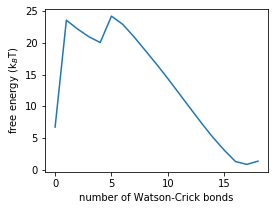

In [74]:
# Add occupations of all 0 Watson Crick bonds together
new_occupation = [sum(occupation[:4])] + list(occupation[4:])
f,ax = pl.subplots(1,1,figsize = (4,3))
pl.plot(-np.log(new_occupation))
ax.set_xlabel('number of Watson-Crick bonds')
ax.set_ylabel('free energy (k$_B$T)')
pl.show()

## Average free energy over several runs

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys


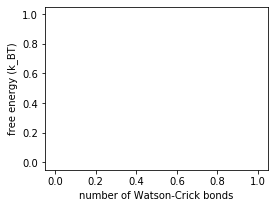

In [339]:
def get_free_energy(occupation):
    # Adds all 0 bonds together
    # Uses unbound state as zero free energy point
    # Fails if any bin has no population
    new_occupation = np.array([sum(occupation[:4])] + list(occupation[4:])) #concatenating lists
    fe = -np.log(new_occupation)
    fe = fe - fe[0]+1e-6
    return fe
# Ignores inf in data - careful histograms are populated in each bin
fe_estimates = [get_free_energy(occ) for occ in norm_prob[:]]
#print(norm_prob)
#print(fe_estimates) # inf comes from histogras being empty->norm_prob->free_energy

f,ax = pl.subplots(1,1,figsize = (4,3))
pl.errorbar(np.mean(fe_estimates,axis=0), np.std(fe_estimates,axis=0))
ax.set_xlabel('number of Watson-Crick bonds')
ax.set_ylabel('free energy (k_BT)')
pl.show()

In [384]:
pwd

'/Users/roshanodonnell/PhD/ComputationalModels/Rosh'

# Analysing trap data
- Shows that trap works as expected - nucleotide moves to trap location as given in conf file, within 1000 steps (first recorded step) 

### To Do 
- Print more data? the trapped nucleotde jumps to the trap within 1000 steps (~instantaneous) - how useful are more fine-details - maybe useful if you want to know rate of change of num bonds 
- 

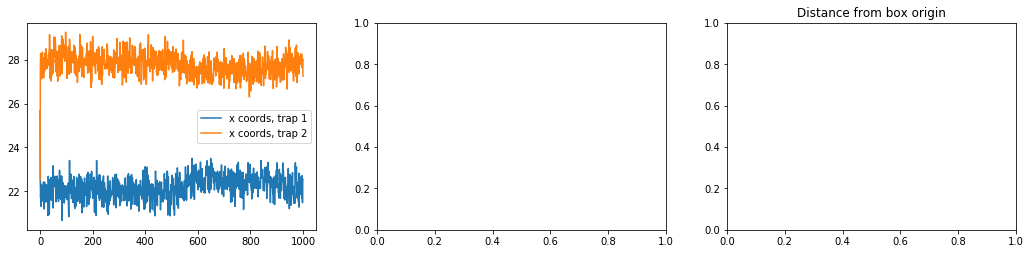

In [342]:
# Initial random nucleotide positions (traps are on 1st and 35th nucleotides)
init_fname = 'MC_trap/RUN2/generated.dat'
with open(init_fname) as f: #file is a list of lines, remove break line char
    traj = [line.rstrip('\n') for line in f]
    pos_0 = traj[3].split(" ")[0:3]
    pos_N = traj[38].split(" ")[0:3]

# Scrape all x,y,z, positions throughout trajectory (groups of 39 nucl * 1000 steps)
tot_num_nuc = 36
num_extra_lines = 3
fname = 'MC_trap/RUN2/trajectory.dat'
with open(fname) as f: #file is a list of lines, remove break line char
    traj = [line.rstrip('\n') for line in f]
    trap_nuc0_traj = []
    trap_nucN_traj = []
    #steps = []
    #print(len(traj)/(tot_num_nuc+num_extra_lines))
    for i in range(int(len(traj)/(tot_num_nuc+num_extra_lines))): # (0,1000) i.e. 1000*1000steps printed
        x0,y0,z0 = traj[i*(tot_num_nuc+num_extra_lines)+3].split(" ")[0:3]
        xN,yN,zN = traj[i*(tot_num_nuc+num_extra_lines)+38].split(" ")[0:3]
        trap_nuc0_traj.append([x0,y0,z0])
        trap_nucN_traj.append([xN,yN,zN])
final_nuc0_traj = [pos_0]+trap_nuc0_traj
final_nucN_traj = [pos_N]+trap_nucN_traj

# Get each of x,y,z from combined data
all_x0 = [float(i[0]) for i in final_nuc0_traj]
all_xN = [float(i[0]) for i in final_nucN_traj]
# all_y0 = [float(i[1]) for i in final_nuc0_traj]
# all_yN = [float(i[1]) for i in final_nucN_traj]
# all_z0 = [float(i[2]) for i in final_nuc0_traj]
# all_zN = [float(i[2]) for i in final_nucN_traj]
fig, ax = pl.subplots(1,3,figsize = (15,4))
fig.tight_layout(pad=3)

ax[0].plot(all_x0,label='x coords, trap 1');ax[0].plot(all_xN,label='x coords, trap 2')
# ax[1].plot(all_y0,label='y coords, trap 1');ax[1].plot(all_yN,label='y coords, trap 2')
# ax[2].plot(all_z0,label='z coords, trap 1');ax[2].plot(all_zN,label='z coords, trap 2')
pl.title('Distance from box origin'); ax[0].legend()#;ax[1].legend();ax[2].legend()
pl.show()

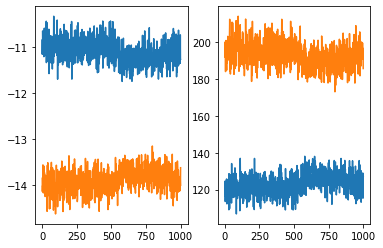

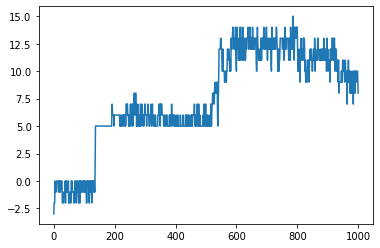

In [345]:
# Get Trap Stiffness
trap_conf_fname = 'MC_trap/RUN2/trap.conf'
with open(trap_conf_fname) as f: #file is a list of lines, remove break line char
    a = [line.rstrip('\n') for line in f]
    #print(all_lines)
    stiff_trap_0 = float(a[4].split(' ')[2])
    stiff_trap_N = float(a[13].split(' ')[2])

# Calculate force and elastic energy
force_x0 = -stiff_trap_0*np.array(all_x0);force_xN = -stiff_trap_N*np.array(all_xN)
energy_x0 = 0.5*stiff_trap_0*np.array(all_x0)**2;energy_xN = 0.5*stiff_trap_N*np.array(all_xN)**2

# Get Reaction coordinate
energy_dat_fname = 'MC_trap/RUN2/energy.dat'
with open(energy_dat_fname) as f: #file is a list of lines, remove break line char
    b = [line.rstrip('\n').strip(' ').split(" ") for line in f] #remove \n, remove spaces, split by inner spaces
    #num_bonds = [int(x[-4]) for x in b]
    react_coord = [float(x[-4])-float(x[-2]) for x in b]
    
    #print(b[200])
    #num_bonds = [int(x[]) for x in b]

# Plot Force vs steps
ax1 = pl.subplot(121)
pl.plot(force_x0[1:]);pl.plot(force_xN[1:])
ax2 = pl.subplot(122)
pl.plot(energy_x0[1:]);pl.plot(energy_xN[1:])
pl.show()

# # Plot Force and Num_bonds
ax3 = pl.subplot(111)
pl.plot(react_coord)
pl.show()



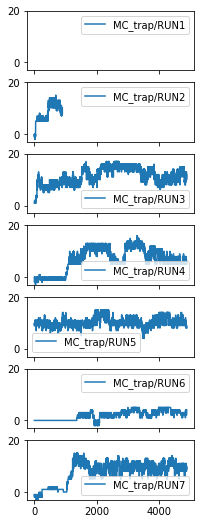

In [443]:
# Collect files and order them by last digits
file_name_t = [f for f in glob.iglob('MC_trap/**', recursive=False) if 'RUN' in f]
file_num_t = [int(''.join(filter(lambda s: s.isdigit(), f))) for f in file_name_t] 
file_num_t, file_name_t = zip(*sorted(zip(file_num_t,file_name_t))) #sort two lists


data_set_t = []
start_t = 0; stop_t = 7
for file in file_name_t[start_t:stop_t]:
    react_coord_t, weights_t = [],[]
    with open(file+'/energy.dat') as f:
        for line in f:
            useful = line.split(' ')[-4:]
            react_coord_t.append(float(useful[0])-float(useful[2])); weights_t.append(float(useful[-1]))
    data_set_t.append([react_coord_t,weights_t])

# Plot reaction coordinate against time steps (not labelled)
f_t,ax_t = pl.subplots(len(data_set_t),1,figsize = (3,9),sharex = True)
chop_t = 100 #100 x1000 steps
data_set_t = [[e[0][chop_t:],e[1][chop_t:]] for e in data_set_t]


for i in range(len(data_set_t)): #
    ax_t[i].plot(data_set_t[i][0],label=f'{file_name_t[i]}') 
    #print(file_name_t[i+start],np.mean(data_set_t[i][0]))
    ax_t[i].set_ylim(-3,20)
    ax_t[i].legend()

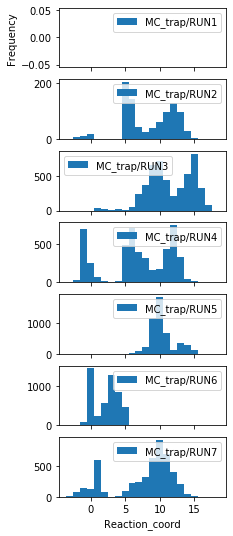

In [444]:
# Show histogram of each reaction coordinate - should be uniform over (-3,18)
f_t,ax_t = pl.subplots(len(data_set_t),1,figsize = (3,9),sharex = True)
_=ax_t[-1].set_xlabel('Reaction_coord')
_=ax_t[0].set_ylabel('Frequency')

min_val_t,max_val_t = -3.0,18
for i in range(len(data_set_t)):
    ax_t[i].hist(data_set_t[i][0],bins=np.arange(min_val_t-0.5,max_val_t+1.5,1),label=f'{file_name_t[i+start_t]}')
    ax_t[i].legend()
    #ax[i].set_ylim(0,100)

In [445]:
pwd

'/Users/roshanodonnell/PhD/ComputationalModels/Rosh'

7
Freq per bin: 222


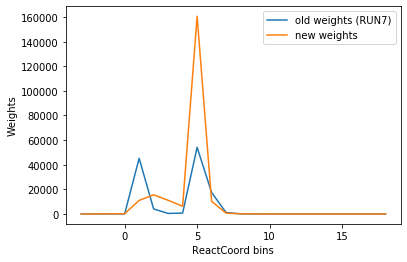

Old Weights: 
 [0.013019, 1.52686, 52.615035, 4.751538, 45173.242028, 4033.483013, 398.263587, 665.434788, 54098.446127, 17403.174545, 1098.454213, 105.199197, 17.522298, 2.272111, 0.226132, 0.019627, 0.00194, 0.000158, 3.4e-05, 5e-06, 2e-06, 1e-06] 

New Weights: 
 [0.016849, 1.585872, 50.872584, 124.69257, 10998.408913, 15520.961367, 11052.190388, 6219.470951, 160660.838653, 10220.151531, 616.192708, 41.854297, 2.143095, 0.091156, 0.021745, 0.005623, 0.00117, 0.000179, 4.4e-05, 7e-06, 2e-06, 1e-06]


In [454]:
# Get old weights
old_w_file_t = 'MC_trap/RUN7/wfile.txt'
old_w_t = []
with open(old_w_file_t) as f:
        for line in f:
            old_w_t.append(float(line.split(' ')[-1]))

# Create new weights based on old histogram (last data_set_t entry; data_set_t[-1][0])
print(len(data_set_t))
n,b = np.histogram(data_set_t[-1][0],bins=np.arange(min_val-0.5,max_val+1.5,1))
mean_t = len(data_set_t[-1][0])/(max_val_t-min_val_t+1) # i.e. 1000 runs, 22 coords, expect 1000/22 per bin
print(f'Freq per bin: {int(mean_t)}')
# Careful; if run was cut short/didn't end, len(data_set[i][0]) will be too short
res_t = n-mean_t; norm_res_t = res_t/np.std(res_t)
new_w_t = np.round(old_w*np.exp(-norm_res_t),6) #oxDNA goes to 6dp , have just done w'=w*exp(-norm_resid)
new_w_t = [w if w!=0. else 1e-6 for w in new_w_t] #prevents weight=0
        
x_range = np.arange(-3,19,1)
pl.plot(x_range,old_w_t,label=f'old weights ({file_name_t[stop_t-1][-4:]})')
pl.plot(x_range,new_w_t,label='new weights')
pl.xlabel('ReactCoord bins');pl.ylabel('Weights')
#pl.xlim(-3,18)#;pl.ylim(0,1)
pl.legend();pl.show()
print('Old Weights: \n',old_w_t,'\n')
print('New Weights: \n',new_w_t)

In [434]:
# Writing a new wfile.txt
col1_t = [0,0,0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
col2_t = [3,2,1]+19*[0]

file = open('MC_trap/RUN8/wfile.txt', 'w')
for i in range(len(col1_t)):
    write_str_t = f'{col1_t[i]} {col2_t[i]} {new_w_t[i]}\n'
    file.write(write_str_t)
file.close()